<h1>Programmatically accessing, processing, and visualizing 3DEP data using USGS 7.5' Quadrangles<h1>

<h2>Table of Contents<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"><li><span><a href="#Authors" data-toc-modified-id="Authors-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Authors</a></span></li><li><span><a href="#Purpose" data-toc-modified-id="Purpose-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Funding" data-toc-modified-id="Funding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Funding</a></span></li><li><span><a href="#Keywords" data-toc-modified-id="Keywords-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Keywords</a></span></li><li><span><a href="#Citation" data-toc-modified-id="Citation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Citation</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Library-Imports" data-toc-modified-id="Library-Imports-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Library Imports</a></span></li><li><span><a href= "Define-Functions" data-toc-modified-id="Define-Functions-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Define Functions</a></span></ul><li><span><a href="#Data-Access-and-Visualization" data-toc-modified-id="Data-Access-and-Visualization-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Data Access and Visualization</a></span><ul class="toc-item"><li><span><a href="#Access-3DEP-Data" data-toc-modified-id="Access-3DEP-Data-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Access 3DEP Data</a></span></li><li><span><a href="#Create-Interactive-Ipyleaflet-Map-And-Define-AOI" data-toc-modified-id="Create-Interactive-Ipyleaflet-Map-And-Define-AOI-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Create Interactive Ipyleaflet Map and Define AOI</a></span></li><li><span><a href="Find-Intersecting-3DEP-Polygons" data-toc-modified-id="Find-Interseciting-3DEP-Polygons-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Find Intersecting 3DEP Polygons</a></span></li></ul></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Data Processing</a></span><ul class="toc-item"></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Resources" data-toc-modified-id="Resources-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Resources</a></span></li></div>
    
<h2>Authors</h2>
<a id='#Authors'></a>

<h2>Purpose</h2>
<a id='#Purpose'></a>

The 3-D Elevation Program (3DEP), managed by the U.S. Geological Survey (USGS) National Geospatial Program, is an ongoing effort to provide high-quality topographic data for the entire conterminous United States. There are currently over 1800 3DEP datasets consisting of >37 trillion individual points and covering an area of > 6 million $km^{2}$.

While 3DEP data can be downloaded in the web browser from a variety of resources, it may benefit some users to programmatically access 3DEP point cloud data from a specific area of interest directly to their local directory. 3DEP data This notebook documents a workflow for accessing, processing, and visualizing data from the 3D Elevation Program (3DEP). The workflow capitalizes on available API and cloud resources allowing for highly compututationally expensive and intensive processes to be conducted and thereby not requiring high-end computational power from the user's local workstation.

A 7.5 minute quadrangle map covers an area of 49 to 70 square miles (130 to 180 km2). ###Worth thinking about how many points will be within each quad in this case.

<h4>Specific features of this notebook</h4>
    
- The user inputs a USGS 7.5' quad ID (can be found here: https://www.usgs.gov/faqs/where-can-i-find-indexes-usgs-topographic-maps) and requests the data within the quad footprint.
    
- The corresponding 3DEP point cloud dataset is accessed programmatically from the <a href="https://registry.opendata.aws/usgs-lidar/"> Amazon Web Services (AWS) public ept (Entwine Point Tile) bucket, implementing the user-defined AOI and made available for subsequent processing.

- Flexibile and customizable PDAL pipelines are available for reclassifying, filtering, and computing derivate products based on user-defined specifications.
 
- DEM (DTM/DSM) generation with option to save (or not) point cloud data.

- Point cloud data and/or derivative products are saved to local directory or local path defined by user.

<h4>Additional resources</h4>
Two additional Python-based workflow have been developed and are availble in Jupyter Notebook format for: <br>
  
1. <a href="http://localhost:8888/notebooks/notebooks/3DEP_pointcloud_access_processing_DTM_creation.ipynb#Programmatically-accessing,-processing,-and-visualizing-USGS-3D-Elevation-Program-(3DEP)-data-for-user-defined-area-of-interest.ipynb"> Programmatically accessing, processing, and visualizing USGS 3D Elevation Program (3DEP) data for user-defined area of interest </a>.

2. <a href="https://github.com/cmspeed/OT_3DEP_Workflows/blob/main/notebooks/Canopy_Height_Model_From_3DEP_Data.ipynb"> Accessing 3DEP point cloud data and creating a canopy height model (CHM) </a>.

<h2>Funding</h2>
<a id='#Funding'></a>
OpenTopography is supported by the National Science Foundation under Award Numbers 1948997, 1948994 & 1948857. Funding for 3DEP workflow developement entitled "Enhancing usability of 3DEP data and web services with Jupyter notebooks"  was provided through the Community for Data Integration (CDI).

<h2>Keywords</h2>
<a id='#Keywords'></a>

keywords=["OpenTopography","USGS", "3DEP", "PDAL"]

<h2>Citation</h2>


## 6. Setup

### 6.1 Getting Started
This notebook provides a self-contained workflow for accessing, processing, and visualizing 3DEP point cloud data. There are two options for performing this workflow:

1. Download this Jupyter notebook (.ipynb file) to your local file system. 
    - Create a virtual environement containing the required dependencies (see below).
    - Run Juypter notebook on local machine.
    - Data download limits will be dependent on user's available hard drive storage.
    <br/><br/>
2. Launch the interactive Jupyter notebook on Google Colaboratory.
    - Does not require creation of a virtual environment or installation on local filesystem.
    - Requires Google account and access to personal Google Drive folder.
    - Data download limits will be dependent on user's available Google Drive storage. 
    - If you wish to run this notebook in Google Colaboratory click the 'Open in Colab' badge below. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cmspeed/OT_3DEP_Workflows/blob/main/notebooks/Programmatically_accessing_3DEP_data_using_USGS_7.5_Quadrangles.ipynb)

<h3> 6.1 Library Imports</h3>
<a id='#Library-Imports-6.1'></a>


### (Optional) - Run Notebook in Google Colaboratory Environment 

In [ ]:
### Exectute this block of cells if running on Google Colab
!git clone https://github.com/cmspeed/OT_3DEP_Workflows

In [ ]:
# Installs Conda, which is the easiest way to install PDAL in the Google Colab environment
# This will trigger a notification that the "Your session crashed for an unknown reason." 
# This is normal. Execute next cell.
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
# Import Conda and install PDAL ---- Takes 1-2 minutes
import condacolab
condacolab.check()
!mamba install -q python-pdal

In [ ]:
#  Install the remaining dependencies
!pip install -r OT_3DEP_Workflows/requirements.txt

In [ ]:
# Mount your Google Drive for saving content
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Import Packages (Google Colab Only)
import os
import json
import pdal
import gdal
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import ipyleaflet
import ipywidgets as widgets
from shapely.geometry import shape, Point, Polygon
from shapely.ops import transform
import requests
import pyproj
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from tqdm import tqdm

In [ ]:
### Runtime must be restarted after the above executes before import of PDAL will be successful!
### On Google Colab ribbon click "Runtime" > "Restart Runtime".  
### Do not execute any of the previous cells. Execute the following cells only.

**If running Google Colab, proceed to 6.2 Define Functions, and do not run next cell (6.1.2)**

#### 6.1.2.  Option 2 - Install and Run Notebook on Local Machine

In [1]:
# Import Packages (Local Machine Only)
import os
import json
import pdal
from osgeo import gdal
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import ipyleaflet
import ipywidgets as widgets
from shapely.geometry import shape, Point, Polygon
from shapely.ops import transform
import requests
import pyproj
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from tqdm import tqdm
import wget
import zipfile
import io

<h3>6.2 Define Functions</h3>
<a id='#Define-Functions-6.2'></a>

The functions below are used throughout the rest of the notebook and are included here for clarity.

```gcs_to_proj()``` is a function to project from geographic coordinates, WGS84 (EPSG: 4326), to Web Mercator projection (EPSG: 3857).

```import_shapefile_to_shapely()``` is a function to read a user's shapefile and make a shapely object.

```handle_draw()``` is a function for interactive drawing on ipyleaflet maps and storing the polygon for use in requesting point cloud data.

```build_pdal_pipeline()``` is a function used to construct the pdal pipeline to request/process the point cloud data from AWS ept public bucket.

```make_DEM_pipeline``` is a function used to construct pdal pipeline to perform steps in ```build_pdal_pipeline()``` and create a DEM (DSM or DTM) from the point cloud data.

These functions can be modified as the user sees fit; however, they are designed to work 'out of the box'.

**Modify this to reproject from ANY CRS to 3857** <br>
**Modify to use | for clarity**

In [2]:
def gcs_to_proj(poly):
    """
    Function for reprojecting polygon shapely object from geographic coordinates (EPSG:4326) 
    to Web Mercator (EPSG: 3857)). 
    
    :param poly: shapely polygon for user area of interest (AOI)
    """
    wgs84 = pyproj.CRS("EPSG:4326")
    web_mercator = pyproj.CRS("EPSG:3857")
    project = pyproj.Transformer.from_crs(wgs84, web_mercator, always_xy=True).transform
    user_poly_proj3857 = transform(project, poly)
    return(user_poly_proj3857)

def import_shapefile_to_shapely(path):
    """
    Conversion of shapefile to shapely object.
    
    :param path: location of shapefile on user's local filesystem
    """
    shapefile_path = path
    gdf = gpd.read_file(shapefile_path)
    user_shp = gdf.loc[0, 'geometry']
    user_shp_epsg3857 = gcs_to_proj(user_shp)
    user_AOI = [[user_shp, user_shp_epsg3857]]
    return user_AOI
    
def handle_draw(target, action, geo_json):
    """
    Allow user to draw area of interest (AOI) on interactive ipyleaflet map.
    
    :param extent_epsg3857: polygon for user-defined AOI
    :param usgs_3dep_dataset_name: name of 3DEP dataset which AOI overlaps
    :param resolution: The desired resolution of the pointcloud based on the following definition:
    """
        
    geom = dict(geo_json['geometry'])
    user_poly = shape(geom)
    user_poly_proj3857 = gcs_to_proj(user_poly)
    print('AOI is valid and has boundaries of ', user_poly_proj3857.bounds)
    user_AOI.append((user_poly, user_poly_proj3857))  #for various reasons, we need user AOI in GCS and EPSG 3857

def build_pdal_pipeline(extent_epsg3857, usgs_3dep_dataset_name, pc_resolution, filterNoise = False,
                        reclassify = True, savePointCloud = True, pc_outName = 'filter_test', pc_outType = 'laz'):

    """
    Build pdal pipeline for requesting, processing, and saving point cloud data.
    
    Parameters:
    :param extent_epsg3857: Polygon for user-defined AOI in Web Mercator projection (EPS:3857)
                            usgs_3dep_dataset_name: name of 3DEP dataset which AOI overlaps. Polygon is generated 
                            either through the 'handle_draw' methor or by inputing their own coordinates.
                            This parameter is set automatically when the user-defined AOI is chosen.
    :param usgs_3dep_dataset_name: Name of the 3DEP dataset that the data will be obtained. This parameter is set 
                                automatically when the user-defined AOI is chosen.
    :param pc_resolution: The desired resolution of the pointcloud based on the following definition:
        
                        Source: https://pdal.io/stages/readers.ept.html#readers-ept
                            A point resolution limit to select, expressed as a grid cell edge length. 
                            Units correspond to resource coordinate system units. For example, 
                            for a coordinate system expressed in meters, a resolution value of 0.1 
                            will select points up to a ground resolution of 100 points per square meter.
                            The resulting resolution may not be exactly this value: the minimum possible 
                            resolution that is at least as precise as the requested resolution will be selected. 
                            Therefore the result may be a bit more precise than requested.
                            
    :param filterNoise: Option to remove points from USGS Class 7 (noise).
    :param savePointCloud: Option to save (or not) the point cloud dataset.
    :param pc_outName: Desired name of file on user's local filesystem. If savePointcloud = False, 
                       this should be outName = ''
    :param pc_outType:  Desired file extension. Input must be either 'las' or 'laz'. If a different file type is
    :param requested,the user will get error stating "Extension must be 'las' or 'laz'". If savePointcloud = False, 
        this should be outType = ''
    :raise Exception: If user passes in argument that is not 'dtm' or 'dsm'
    """
    
    url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/{}/ept.json".format(usgs_3dep_dataset_name)
    
    ### TODO: Add an option to choose an output CRS
    ### TODO: Add option to output shapefile of the bounding box. 
    ### TODO: Consider restructuring pipeline construction with list comprehension
              #pipline = [dict(zip([1],[stage])) for x in range(1,len(stages))], or similar.
    ### Important note: smrf cannot be run in streaming mode
    ### TODO: Test performance in and out of streaming mode. Could create a execute_pipeline() 
        ###   that tests whether streaming is possible.
        
    #this is the basic pipeline which only accesses the 3DEP data. There is an optional
    pointcloud_pipeline = {
            "pipeline": [
                
                {
                    "type": "readers.ept",
                    "filename": str(url),
                    "polygon": str(extent_epsg3857),
                    "requests": 3,
                    "resolution": pc_resolution
                }
            ]
    }
    
    if filterNoise == True:
        
        filter_stage = {
            "type":"filters.range",
            "limits":"Classification![7:7]"
        }
        
        pointcloud_pipeline['pipeline'].append(filter_stage)
    
    if reclassify == True:
        
        remove_classes_stage = {
            "type":"filters.assign",
            "value":"Classification = 0"
        }
        
        classify_ground_stage = {
            "type":"filters.smrf"
        }
        
        reclass_stage = {
            "type":"filters.range",
            "limits":"Classification[2:2]"
        }
        
        pointcloud_pipeline['pipeline'].append(remove_classes_stage)
        pointcloud_pipeline['pipeline'].append(classify_ground_stage)
        pointcloud_pipeline['pipeline'].append(reclass_stage)
        
    if savePointCloud == True:
        
        if pc_outType == 'las':
            savePC_stage = {
                "type": "writers.las",
                "filename": str(pc_outName)+'.'+ str(pc_outType)
            }
        elif pc_outType == 'laz':    
            savePC_stage = {
                "type": "writers.las",
                "compression": "laszip",
                "filename": str(pc_outName)+'.'+ str(pc_outType)
            }
        else:
            raise Exception("pc_outType must be 'las' or 'laz'.")

        pointcloud_pipeline['pipeline'].append(savePC_stage)
        
    return pointcloud_pipeline


def make_DEM_pipeline(extent_epsg3857, usgs_3dep_dataset_name, pc_resolution, dem_resolution,
                      filterNoise = True, reclassify = True, savePointCloud = False, pc_outName = 'filter_test', 
                      pc_outType = 'laz', demType = 'dtm', gridMethod = 'idw', dem_outName = 'dem_test', 
                      dem_outExt = 'tif', driver = "GTiff"):
    
    """
    Build pdal pipeline for creating a digital elevation model (DEM) product from the requested point cloud data. The 
    user must specify whether a digital terrain (bare earth) model (DTM) or digital surface model (DSM) will be created, 
    the output DTM/DSM resolution, and the gridding method desired. 

    The `build_pdal_pipeline() method is used to request the data from the Amazon Web Services ept bucket, and the 
    user may define any processing steps (filtering or reclassifying). The user must also specify whether the point 
    cloud should be saved or not. Saving the point cloud is not necessary for the generation of the DEM. 

    
    :param extent_epsg3857: Polygon for user-defined AOI in Web Mercator projection (EPS:3857)
                         usgs_3dep_dataset_name: name of 3DEP dataset which AOI overlaps. Polygon is generated 
                         either through the 'handle_draw' methor or by inputing their own coordinates.
                         This parameter is set automatically when the user-defined AOI is chosen.
    :param usgs_3dep_dataset_name: Name of the 3DEP dataset that the data will be obtained. This parameter is set 
                                automatically when the user-defined AOI is chosen.
    :param pc_resolution: The desired resolution of the pointcloud based on the following definition:

                        Source: https://pdal.io/stages/readers.ept.html#readers-ept
                            A point resolution limit to select, expressed as a grid cell edge length. 
                            Units correspond to resource coordinate system units. For example, 
                            for a coordinate system expressed in meters, a resolution value of 0.1 
                            will select points up to a ground resolution of 100 points per square meter.
                            The resulting resolution may not be exactly this value: the minimum possible 
                            resolution that is at least as precise as the requested resolution will be selected. 
                            Therefore the result may be a bit more precise than requested.

    :param dem_resolution: Desired grid size (in meteres) for output raster DEM 
    :param filterNoise: Option to remove points from USGS Class 7 (noise).
    :param savePointCloud: Option to save (or not) the point cloud dataset.
    :param pc_outName: Desired name of file on user's local filesystem. If savePointcloud = False, 
                  this should be outName = ''
    :param pc_outType:  Desired file extension. Input must be either 'las' or 'laz'. If a different file type is requested,
                  the user will get error stating "Extension must be 'las' or 'laz'". If savePointcloud = False, 
                  this should be outType = ''
    :param demType: Type of DEM produced. Input must 'dtm' (digital terrain model) or 'dsm' (digital surface model).
    :param gridMethod: Method used. Options are 'min', 'mean', 'max', 'idw'. ELABORATE MORE HERE.
    :param dem_outName: Desired name of DEM file on user's local filesystem.
    :param dem_outExt: DEM file extension. ELABORATE MORE HERE.
    :param driver: Driver used. ELABORATE MORE HERE.
    :raise Exception: If user passes in argument that is not 'dtm' or 'dsm'
    """

    dem_pipeline = build_pdal_pipeline(extent_epsg3857, usgs_3dep_dataset_name, pc_resolution,
                                              filterNoise, reclassify, savePointCloud, pc_outName, pc_outType)
    
    if demType == 'dsm':
        dem_stage = {
                "type":"writers.gdal",
                "filename":str(dem_outName)+ '.' + str(dem_outExt),
                "gdaldriver":driver,
                "nodata":-9999,
                "output_type":gridMethod,
                "resolution":float(dem_resolution),
                "gdalopts":"COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        }
    
    elif demType == 'dtm':
        groundfilter_stage = {
                "type":"filters.range",
                "limits":"Classification[2:2]"
        }

        dem_pipeline['pipeline'].append(groundfilter_stage)

        dem_stage = {
                "type":"writers.gdal",
                "filename":str(dem_outName)+ '.' + str(dem_outExt),
                "gdaldriver":driver,
                "nodata":-9999,
                "output_type":gridMethod,
                "resolution":float(dem_resolution),
                "gdalopts":"COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        }
    
    else:
        raise Exception("demType must be 'dsm' or 'dtm'.")
        
        
    dem_pipeline['pipeline'].append(dem_stage)
    
    return dem_pipeline

## 7. Data Access and Visualization

<h3> 7.1 Access 3DEP Data Polygons</h3>
<a id='#Access-3DEP-Data-7.1'></a>

Executing the next two cells will allow you to select a Area of Interest (AOI) for which point cloud data will be retreived. The map includes a Geo
JSON file indicating where 3DEP point cloud data are available.

In [3]:
# Get GeoJSON file for 3DEP outlines from URL 

#this needs to be modified to always make a new pull, even if it exists because it is possible updated at the source.
url = 'https://raw.githubusercontent.com/hobuinc/usgs-lidar/master/boundaries/resources.geojson'
r = requests.get(url)
with open('resources.geojson', 'w') as f:
    f.write(r.content.decode("utf-8"))

with open('resources.geojson', 'r') as f:
    data = json.load(f)

geo_json_3DEP = ipyleaflet.GeoJSON(data=data, style = {'color': 'green', 'opacity':1, 
                                       'weight':1.9, 'fillOpacity':0.1})

with open('resources.geojson', 'r') as f:
    df = gpd.read_file(f)

projected_geoms = []

print('projecting 3DEP polygons to web mercator (EPSG:3857)')
for geometry in tqdm(df['geometry']):
        projected_geoms.append(gcs_to_proj(geometry))

geometries_GCS = df['geometry']
geometries_EPSG3857 = gpd.GeoSeries(projected_geoms)
names = df['name']
urls = df['url']
num_points = df['count']

projecting 3DEP polygons to web mercator (EPSG:3857)


100%|█████████████████████████████████████████████| 1814/1814 [00:08<00:00, 213.84it/s]


In [4]:
#download and unzip usgs 7.5 quadrangle footprints and save the files to a new directory called '\tmp'
if not os.path.exists('quad24.shp'):
    quad_url = 'https://mrdata.usgs.gov/reference/quad24.zip'
    local_path = 'tmp/'
    print("Downloading USGS 7.5' quadrangle footprint shapefile...")
    r = requests.get(quad_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=local_path) # extract to folder called tmp
    filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'shp', 'shx'] if y.endswith(ending)] 
    print(filenames)

['quad24.dbf', 'quad24.shp', 'quad24.shx']


In [5]:
#make geopandas dataframe from the .shp and inspect first 5 records
dbf, shp, shx = [filename for filename in filenames]
quads = gpd.read_file(local_path + shp)
quads_ID = quads['QUAD24_ID']
geometries_GCS_quads = quads['geometry']
quads.head() #first 5 records in dataframe

,QUAD24_ID,Q24CODE,Q100COD,Q250COD,QUAD24NAME,QUAD24NAM2,QUAD100NAM,QUAD250NAM,STATE1,STATE2,STATE3,STATE4,X,Y,AREA,CORNER,CELL,geometry
0,1,49114NWF1,49114NW,49114,GOOSE LAKE,"GOOSE LAKE, MT",SAINT MARY,CUT BANK,MT,None,None,None,-113.3125,48.9375,1.273105e+08,NW,F1,"POLYGON ((-113.37500 49.00000, -113.25000 49.0..."
1,2,49114NWG1,49114NW,49114,HALL COULEE,"HALL COULEE, MT",SAINT MARY,CUT BANK,MT,None,None,None,-113.1875,48.9375,1.273067e+08,NW,G1,"POLYGON ((-113.25000 49.00000, -113.12500 49.0..."
2,3,49114NWH1,49114NW,49114,EMIGRANT GAP,"EMIGRANT GAP, MT",SAINT MARY,CUT BANK,MT,None,None,None,-113.0625,48.9375,1.273067e+08,NW,H1,"POLYGON ((-113.12500 49.00000, -113.00000 49.0..."
3,4,49114NEA1,49114NE,49114,BUSHNELL HILL,"BUSHNELL HILL, MT",CUT BANK,CUT BANK,MT,None,None,None,-112.9375,48.9375,1.273104e+08,NE,A1,"POLYGON ((-113.00000 49.00000, -112.87500 49.0..."
4,5,49114NEB1,49114NE,49114,DEL BONITA,"DEL BONITA, MT",CUT BANK,CUT BANK,MT,None,None,None,-112.8125,48.9375,1.273102e+08,NE,B1,"POLYGON ((-112.87500 49.00000, -112.75000 49.0..."


Note the column headings, specifically the ```QUAD24ID```, ```QUAD24NAME```, and ```geometry``` columns. The geometry is currently in geographic coordinate system WGS84 (EPSG: 4326). These will need to be reprojected to Web Mercator (EPSG: 3857), which is the projected coordinate system of the 3DEP EPT Tiles hosted in the Amazon bucket. Below the shapefile is converted to a GeoJSON format, and the reprojection happens in a subsequent cell. The below cell may raise a warning related to the pandas use of Int65Index, but it should not cause issues.

In [6]:
#convert gpd dataframe to GeoJSON format
quads.to_file('usgs_quadrangles.geojson', driver='GeoJSON')

with open('usgs_quadrangles.geojson', 'r') as f:
    data = json.load(f)
    
quads_geojson = ipyleaflet.GeoJSON(data=data, style = {'color': 'green', 'opacity':1, 
                                       'weight':1.9, 'fillOpacity':0.1})

/Users/cole/anaconda3/envs/pointcloud/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Input USGS 7.5 Quadrangle ID (e.g., 52007)

Enter Quadrangle ID below. If the user does not know the QuadID for their area of interest, an interactive map to find the ID can be accessed here: https://www.usgs.gov/faqs/where-can-i-find-indexes-usgs-topographic-maps)

In [7]:
# Default QuadID 35000, which overlaps with an existing 3DEP datset. NOTE: Not all Quads overlap 3DEP data currently.
quad_ID = '52007'

In [8]:
# Required steps to get the geometry of the user-defined quad and make necessary projections
user_quad = quads.loc[quads['QUAD24_ID'] == int(quad_ID)]  # Find quad record in geodataframe 
user_quad_geom_GCS = user_quad['geometry'][user_quad.index[0]] # User-selected quad geometry in geographic coords
user_quad_GCS_wtk = user_quad_geom_GCS.wkt # Make WTK layer from geometry
user_quad_geom_EPSG3857 = gcs_to_proj(user_quad_geom_GCS)   # Reproject the footprint to EPSG:3857
user_quad_epsg3857_wtk = user_quad_geom_EPSG3857.wkt #Make WTK layer from projected geometry

Now the quadrangle footprint with the selected ```QUAD24_ID``` as well the 3DEP dataset polygons are added to an interactive ipyleaflet map for visual inspection.

In [9]:
quad_centroid =  list(user_quad_geom_GCS.centroid.coords)[0]

m = ipyleaflet.Map(
    basemap=ipyleaflet.basemaps.Esri.WorldTopoMap,
    center=(quad_centroid[1], quad_centroid[0]),
    zoom=10,
    crs=ipyleaflet.projections.EPSG3857
    )

wlayer_quad = ipyleaflet.WKTLayer(
    wkt_string=user_quad_geom_GCS.boundary.wkt,
    style={"color": "blue"}
)

user_quad_EPSG3857_wtk = user_quad_geom_EPSG3857.wkt

m.add_layer(geo_json_3DEP)  #add 3DEP polygons GeoJSON
m.add_layer(wlayer_quad)

#determine if your quad overlaps one of the existing 3DEP datasets
intersecting_polys = []
overlap = False
for i,geom in enumerate(geometries_EPSG3857):
    if geom.intersects(user_quad_geom_EPSG3857):
        intersecting_polys.append((names[i], geometries_EPSG3857[i], geometries_EPSG3857[i], urls[i], num_points[i]))
        overlap = True

if overlap == True:
    print("Quadrangle", quad_ID, "overlaps the USGS 3DEP dataset with name", intersecting_polys[0][0], 
          ". You may proceed.")
else:
    print("Quad", quad_ID, "doesn't overlap with any USGS 3DEP datasets at this time.")
    
num_pts_est = int((user_quad_geom_EPSG3857.area/intersecting_polys[0][2].area)*(intersecting_polys[0][4]))
area = int(user_quad_geom_GCS.area/1e6)
usgs_3dep_dataset = intersecting_polys[0][0]

user_resolution = widgets.RadioButtons(
    options=[
        (f'Full - All ~{int(num_pts_est):,} points', 1.0),
        (f'High - 2m resolution ~{int(num_pts_est/2):,} points', 2.0),
        (f'Mid  - 5m resolution ~{int(num_pts_est/5):,} points', 5.0),
        (f'Low  - 10m resolution ~{int(num_pts_est/10):,} points', 10.0)
    ],
    layout={'width': 'max-content'},
    disabled = False,
)
widgets.VBox(
    [m,
        widgets.Label(value=f'Full dataset will consist of ~{num_pts_est:,} \
        points from the {usgs_3dep_dataset} 3DEP dataset, or choose desired resolution below.'),
        user_resolution
    ]
)

Quadrangle 52007 overlaps the USGS 3DEP dataset with name USGS_LPC_TX_Central_B1_2017_LAS_2019 . You may proceed.


## 8. Data Processing
PDAL pipelines are useful ways of processing and manipulating point cloud data and creating derivative products. Below you will need to define the processing and/or derivative products which you desire. The ```build_pdal_pipeline()``` function will then construct the appropriate pipeline designed for the user's specifications. Executing this pipeline will request and perform processing on the point cloud data and provide the final result on the user's filesystem.

### 8.1 Construct PDAL Pipeline
The PDAL pipeline is constructed using the ```build_pdal_pipeline()``` function. Explanations of input parameters are can be found in this cell. Importantly, the ```outputs``` parameter is where the user may define the processing and outputs that they wish to produce. 

Paramaters: <br>
```user_quad_geom_EPSG3857```: the user-defined quadrangle area of interest (AOI)<br>
```usgs_3dep_dataset```: the corresponding 3DEP dataset name<br>
```pointcloud_resolution```: point cloud resolution (1m, 2m, 5m, 10m)<br>
```filterNoise```: remove the points of Class 7 (noise); optional<br>
```reclassify```: remove USGS classes and run an SMRF to classify ground points only; optional<br>
```savePointCloud```: specify if point cloud data should be saved to local file system; optional<br>
```pc_outName```: name of point cloud on local file system<br>
```pc_outType```: file type, las or laz (laszip compression). Options are 'las' or 'laz'<br>

In [10]:
dirname = '/Users/cole/Dropbox/unavco/project/ot_repo/OT_3DEP_Workflows/notebooks/quad_tests/'
pointcloud_resolution = user_resolution.value
pc_pipeline = build_pdal_pipeline(user_quad_geom_EPSG3857, usgs_3dep_dataset, pointcloud_resolution, filterNoise = True,
                                  reclassify = False, savePointCloud = True, pc_outName = dirname+'quad35000_mid',
                                  pc_outType = 'laz')

pc_pipeline = pdal.Pipeline(json.dumps(pc_pipeline))

In [11]:
%%time
pc_pipeline.execute_streaming(chunk_size=1000000)

CPU times: user 2min, sys: 8.83 s, total: 2min 8s
Wall time: 1min 48s


46702065

If the user only desires point cloud data, they may stop here. Following is a quick overview showing how ground class may be gridded to create a DTM.

### 8.2 (Optional) DEM generation 
The following pipeline performs the above ```build_pdal_pipeline()``` method and also performs the ```make_DEM_pipeline()``` to produce a DEM (user chooses DSM or DTM). 

Paramaters:  <br>
```AOI_EPSG3857_wtk```: the user-defined area of interest (AOI)<br>
```usgs_3dep_dataset```: the corresponding 3DEP dataset name<br>
```pointcloud_resolution```: point cloud resolution (1m, 2m, 5m, 10m)<br>
```dem_generation```: grid size for dem product (specified in meters)<br>
```filterNoise```: remove the points of Class 7 (noise); optional<br>
```reclassify```: remove USGS classes and run an SMRF to classify ground points only; optional<br>
```savePointCloud```: specify if point cloud data should be saved to local file system; optional<br>
```pc_outName```: name of point cloud on local file system<br>
```pc_outType```: file type, las or laz (laszip compression). Options are 'las' or 'laz'<br>
```demType```: specifies to create digital surface model (DSM) or digital terrain model (DTM)<br>
```gridMethod```: gridding method to use; options: (min, mean, max, idw)<br>
```dem_outName```: name of dem on local file system <br>
```dem_outExt```: extension of file on local file system (must correspond to what is chosen for ```driver```<br>
```driver```: gdal code of the driver (default is "GTiff"; other options can be found at https://gdal.org/drivers/raster/index.html<br>

### Make DSM

In [12]:
dem_resolution = 2.0
dirname = '/Users/cole/Dropbox/unavco/project/ot_repo/OT_3DEP_Workflows/notebooks/quad_tests/dems/'
dem_pipeline = make_DEM_pipeline(user_quad_geom_EPSG3857, usgs_3dep_dataset, pointcloud_resolution, dem_resolution,
                                 filterNoise = True, reclassify = False,  savePointCloud = False, pc_outName = '', 
                                 pc_outType = '', demType = 'dsm', gridMethod='idw', 
                                 dem_outName = dirname+'quad35000_2m_dsm', dem_outExt = 'tif', driver = "GTiff")

dem_pipeline = pdal.Pipeline(json.dumps(dem_pipeline))

In [13]:
%%time
dem_pipeline.execute_streaming(chunk_size=1000000)

CPU times: user 7min 13s, sys: 4min 46s, total: 11min 59s
Wall time: 10min 46s


46702065

### Make DTM

In [15]:
dem_resolution = 2.0
dirname = '/Users/cole/Dropbox/unavco/project/ot_repo/OT_3DEP_Workflows/notebooks/quad_tests/dems/'
dem_pipeline = make_DEM_pipeline(user_quad_geom_EPSG3857, usgs_3dep_dataset, pointcloud_resolution, dem_resolution,
                                 filterNoise = True, reclassify = False, savePointCloud = False, pc_outName = '', 
                                 pc_outType = '', demType = 'dtm', dem_outName = dirname+'quad35000_2m_dtm', 
                                 dem_outExt = 'tif', driver = "GTiff")

dem_pipeline = pdal.Pipeline(json.dumps(dem_pipeline))

In [16]:
%%time
dem_pipeline.execute_streaming(chunk_size=1000000)

CPU times: user 4min 59s, sys: 3min 4s, total: 8min 4s
Wall time: 6min 54s


17516860

### Visualize the DEM

In [17]:
dem_outName = dirname+'quad35000_2m_dtm'
dem_outExt = 'tif'
filename = dem_outName+'.'+dem_outExt
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(float)
data_array

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

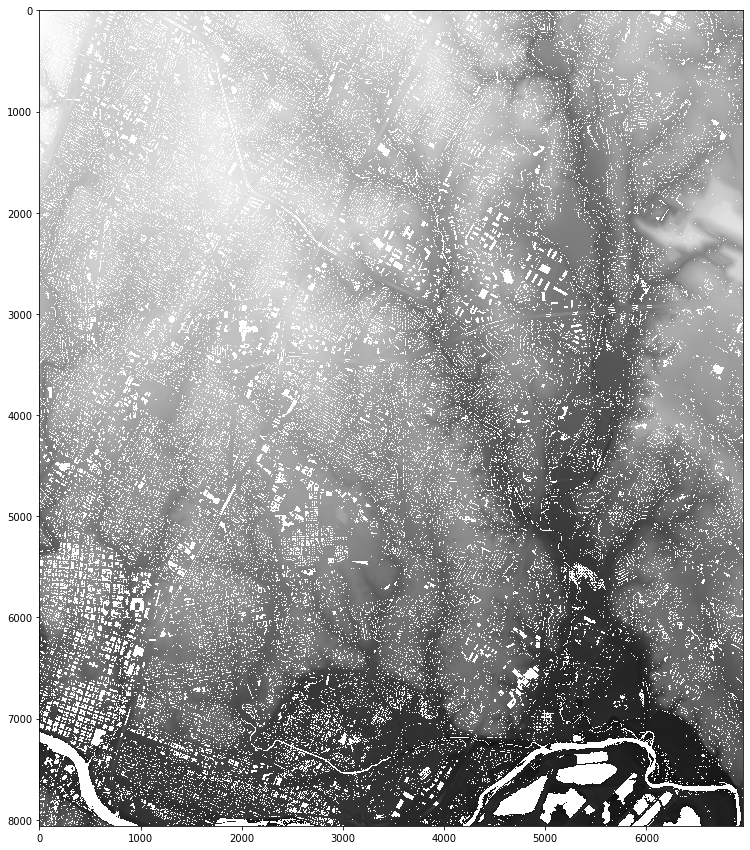

In [18]:
fig,ax = plt.subplots(figsize = (15,15))
masked_array = np.ma.array (data_array, mask=np.isnan(data_array))
cmap = matplotlib.cm.get_cmap("Greys").copy()
cmap.set_bad('white',1.)
ax.imshow(masked_array, interpolation='nearest', cmap='Greys_r');

## Conclusion
This notebook provides a workflow for programmatically accessing, processing, and visualizing point cloud and derivative products for a USGS 7.5' Quadrangle.